
## **Ames House Price Prediction**


### **Introduction**

The goal of this project is to predict the price of a home in Ames, Iowa,
 based on certain characteristics of the home. Basic algorithms such as Linear Regression and random forest will be used.




#### **Exploratory Data Analysis**





In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
sns.set_palette("Set1")

In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [ ]:
train_df= pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train_df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [ ]:
train_df.shape

(1460, 81)

The train set has 80 features and 1 label

In [ ]:
train_num= train_df.select_dtypes(exclude=['object']).drop(['Id', 'MSSubClass'], axis= 1)
train_df_numeric= train_num.copy()

train_cat= train_df.select_dtypes(include=['object'])
train_df_cat= train_cat.copy()
train_df_cat['MSSubClass']= train_df['MSSubClass'].astype(str)

print('The train set has', train_df_numeric.shape[1], 'numeric variables and', train_df_cat.shape[1], 'categorical variables')

The train set has 36 numeric variables and 44 categorical variables


Text(0.5, 1.0, 'Distribution of missing values in the train set')

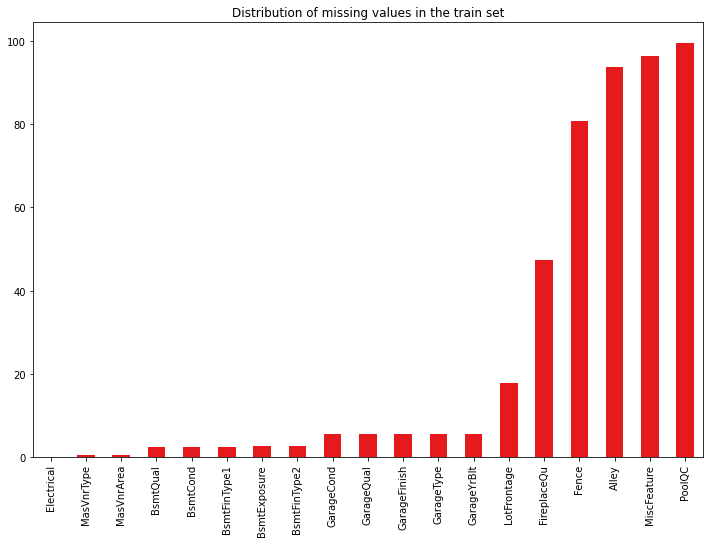

In [ ]:
# Missing values
f = plt.figure(figsize=(12, 8))
missing_values = train_df.isnull().sum()/len(train_df) * 100
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_values.plot.bar()
plt.title('Distribution of missing values in the train set')

'PoolQC', 'Fence' and 'MiscFeature' has more than three-quarters of their values missing. According to the variable description, null values in 'PoolQC' and 'Fence' indicates no pool and fence respectively. The same applies to all features relating to the garage ('GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond'), fireplace ('FireplaceQu') and basement ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2'). Thus, they will be filled with zero during the data cleaning phase.

'MiscFeature' meaning miscellaneous features will be dropped since it does not provide any useful information to the model, given the alarming percentage of missing values. 

As for 'MasVnrType' and 'MasVnrArea', the percentage of missing values is minute, therefore, imputation will be carried out on this features.





##### **Target Variable**

Text(0.5, 1.0, 'Distribution of Sale Price')

<Figure size 864x576 with 0 Axes>

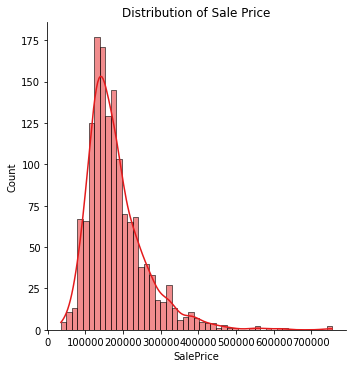

In [ ]:
fig= plt.figure(figsize=(12, 8))
sns.displot(train_df['SalePrice'], kde= True)
plt.title('Distribution of Sale Price')

In [ ]:
print("Skewness: %f" % train_df['SalePrice'].skew())
print("Kurtosis: %f" % train_df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


The distribution of 'SalePrice' shows peakedness and positive skewness but no zero values. This is evident in the skewness and kurtosis values. This shows that the target variable is not normally distributed, as is common with price variables. This will pose a problem when training linear algorithms. Thus log transformation will be carried out on this variable in order to normalise it.

##### **Numeric Variables**

In [ ]:
train_df_numeric.corr()['SalePrice'].abs().sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePrice, dtype: float64

Some of the features are weakly correlated to the target features. These will be considered for dropping especially if they are highly correlated with other features.

Text(0.5, 1.0, 'Correlation of continuous features with Sale Price')

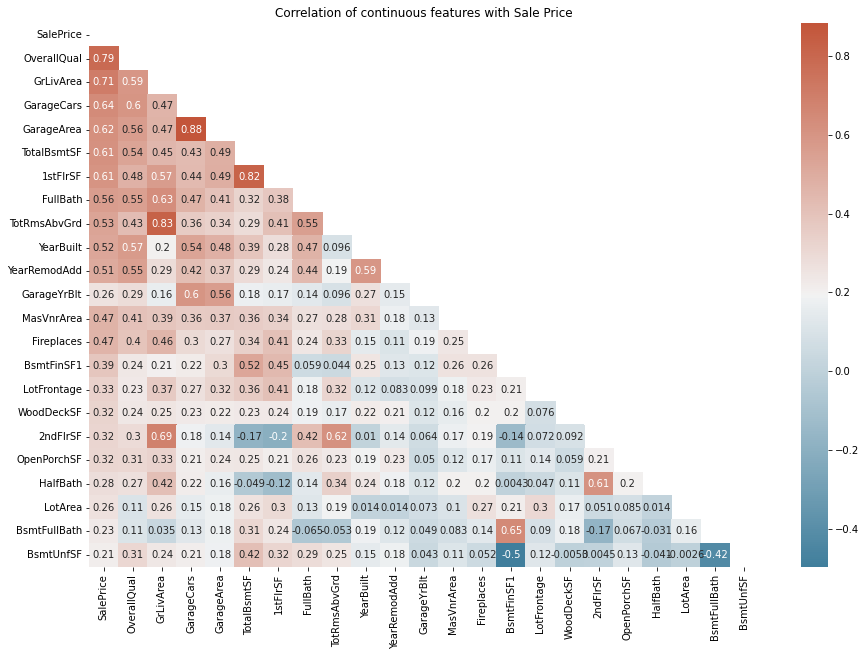

In [ ]:
# Checking for multicollinearity among the first 22 features strongly correlated with SalePrice
f = plt.figure(figsize=(15, 10))
num_cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF',
        'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd','GarageYrBlt', 'MasVnrArea', 'Fireplaces', 
        'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath',
        'BsmtUnfSF']
corr = train_df_numeric[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask=mask, annot= True)
plt.title('Correlation of continuous features with Sale Price')

Highly correlated features:

* 'GarageCars' vs 'GarageArea'
* 'TotalBsmtSF' vs '1stFlrSF'
* 'TotRmsAbvGrd' vs 'GrLivArea' 
* 'YearBuilt' vs 'GarageYrBlt'

In order to prevent multicollinearity, one of the features, lesser correlated with the target variable will be dropped. This inlude:

* 'GarageArea'
* '1stFlrSF'
* 'TotRmsAbvGrd'
* 'GarageYrBlt'

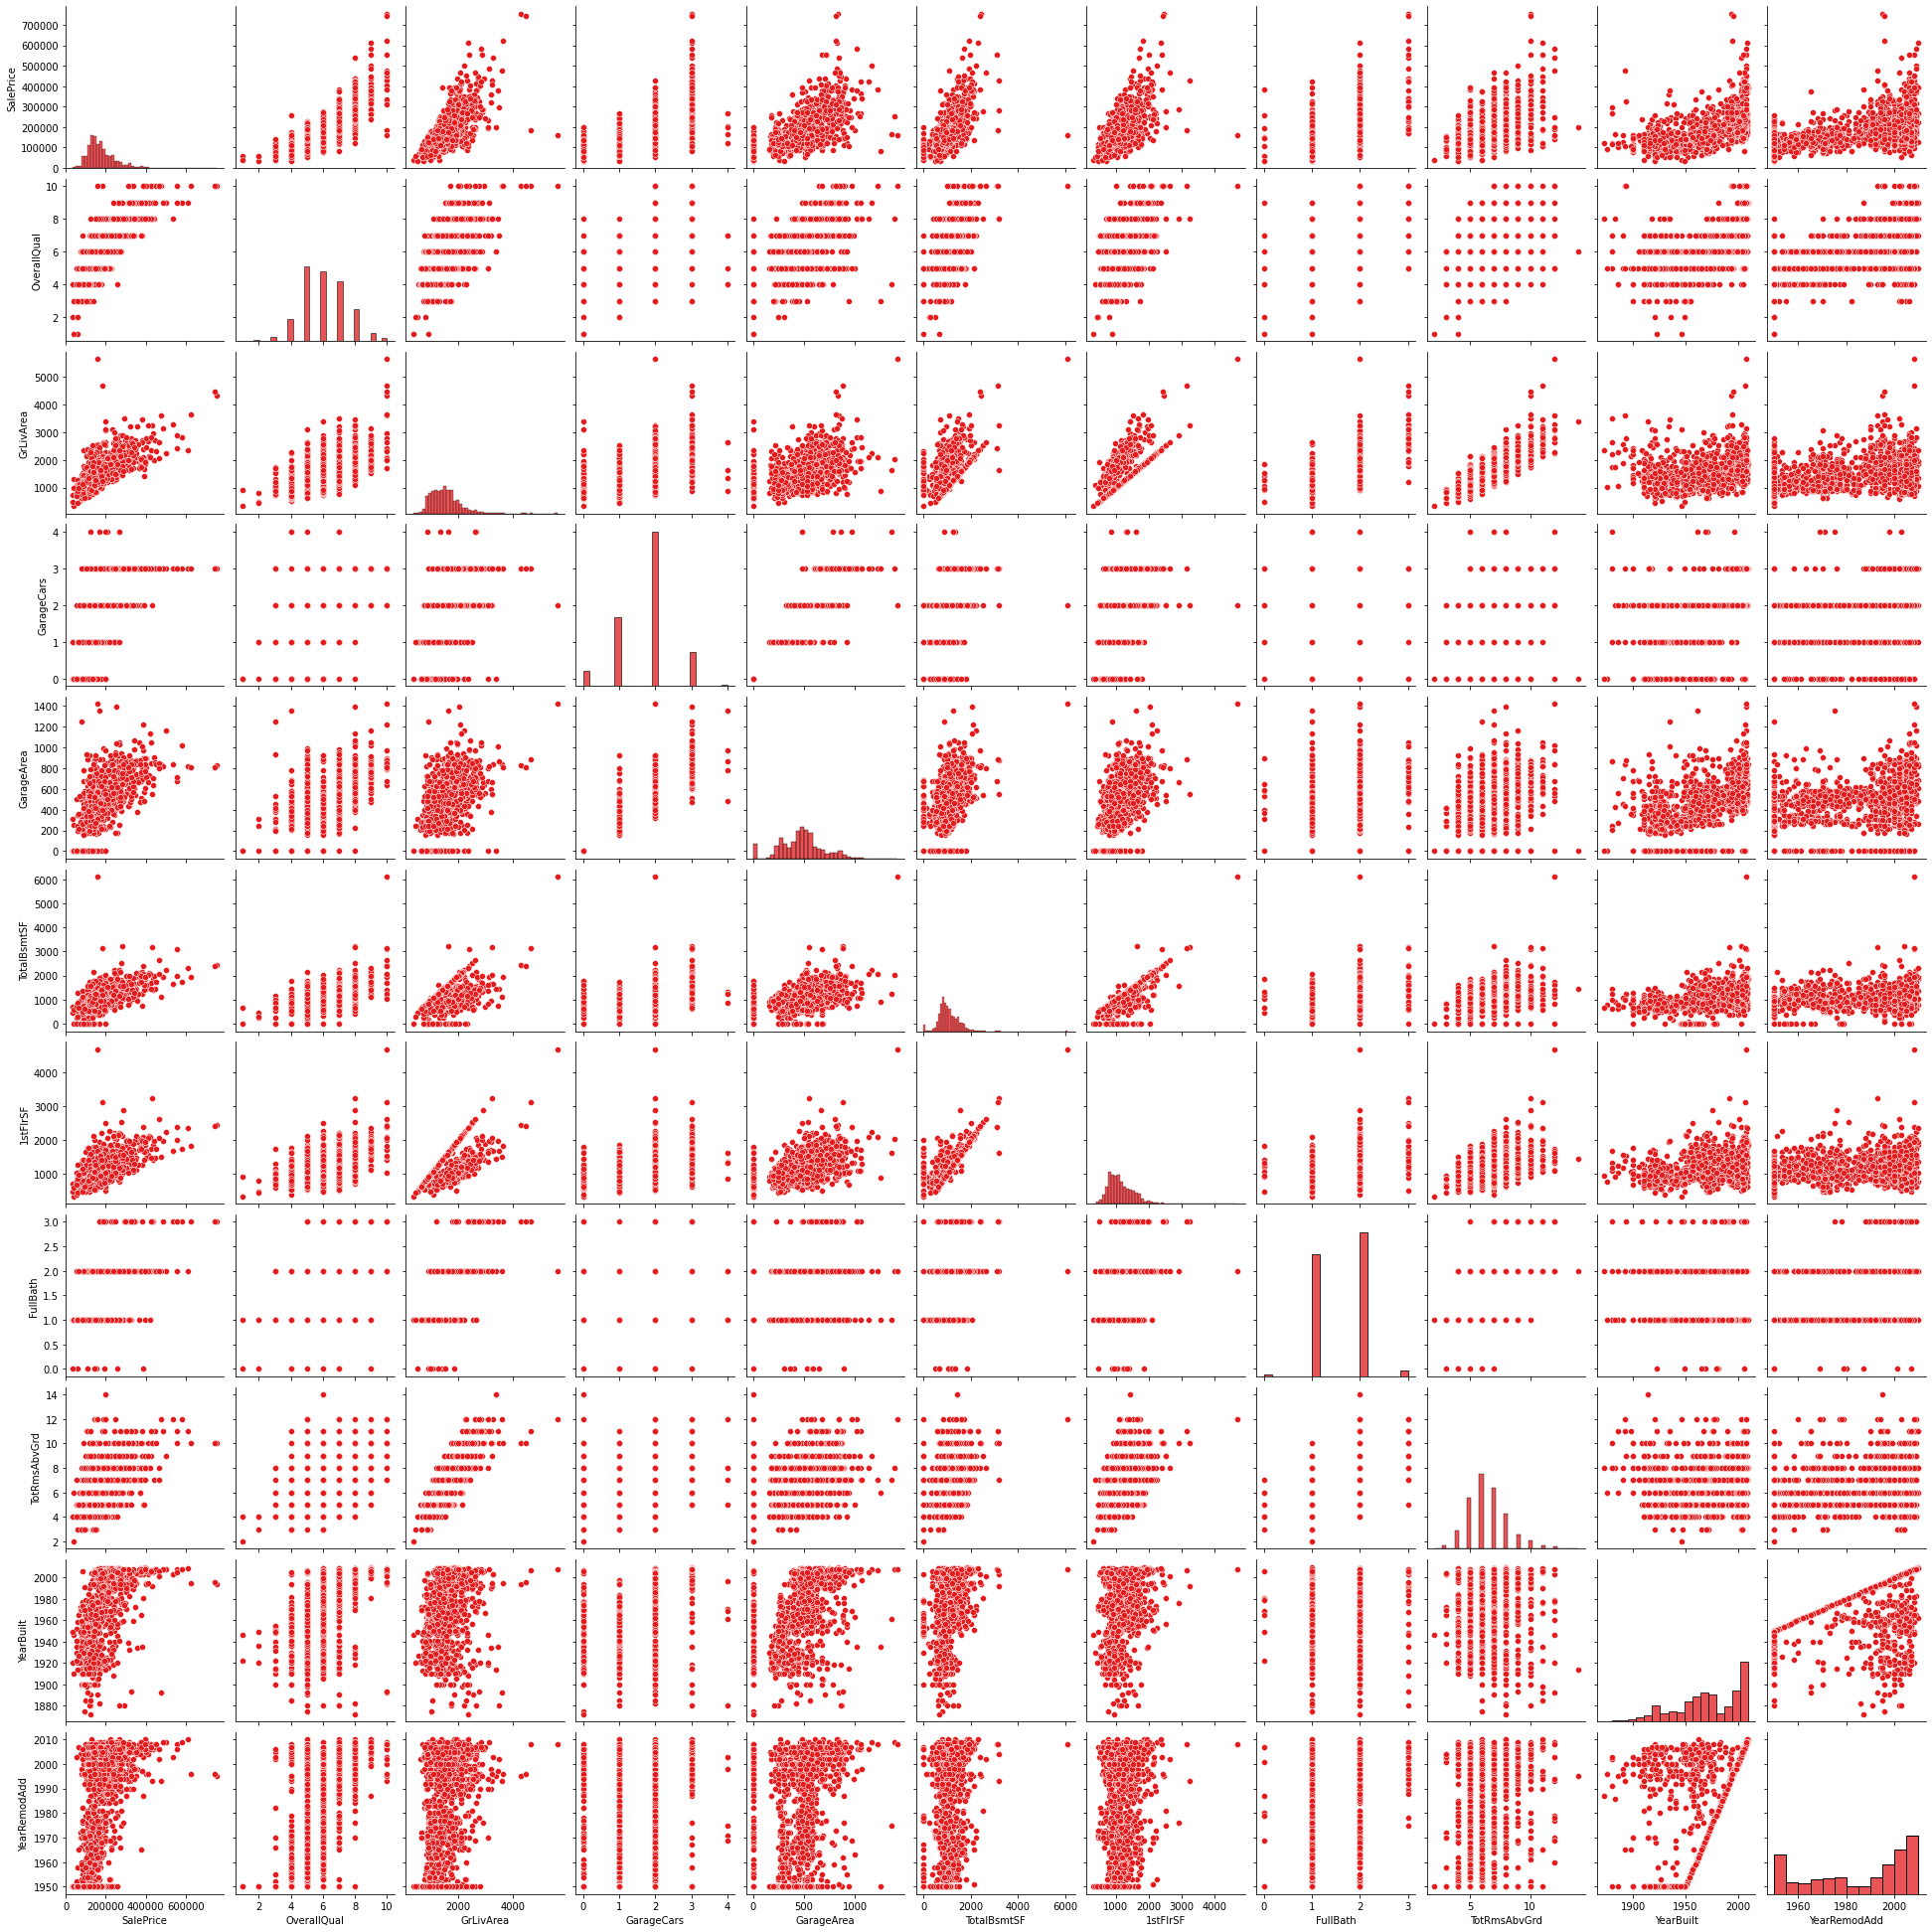

In [ ]:
#Checking for the kind of relationship between the highly correlated features

num_cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF',
        'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']
sns.pairplot(train_df_numeric[num_cols], height = 2.5)

Relationship between 'SalePrice' and variables like 'OverallQual' and 'YearBuilt' is not strictly linear. This will require normalization. Also, their quadratic terms can be additional features.

There are outliers in the numeric variables.

##### **Categorical Variables**

Manual inspection of the categorical variables shows that some are ordinal features which has a meaningful ranking.

In [ ]:
# Ordinal categories

ordinal_cat_features= ['LotShape', 'Utilities','LandSlope','ExterQual','BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 
                       'BsmtFinType2','HeatingQC', 'Electrical', 'KitchenQual','Functional', 'FireplaceQu',
                       'GarageType', 'GarageFinish', 'GarageQual','GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

train_df_cat['LotShape'] = train_df_cat['LotShape'].replace({'Reg': 3, 'IR1': 2, 'IR2': 2, 'IR3': 1})
train_df_cat['Utilities'] = train_df_cat['Utilities'].replace({'AllPub': 2, 'NoSeWa': 1})
train_df_cat['LandSlope'] = train_df_cat['LandSlope'].replace({'Gtl': 3, 'Mod': 2, 'Sev': 1})
train_df_cat['ExterQual'] = train_df_cat['ExterQual'].replace({'Gd': 3, 'TA': 2, 'Ex': 4, 'Fa': 1})
train_df_cat['BsmtQual'] = train_df_cat['BsmtQual'].replace({'Gd': 3, 'TA': 2, 'Ex': 4, 'Fa': 1})
train_df_cat['BsmtCond'] = train_df_cat['BsmtCond'].replace({'TA':3, 'Gd':4, 'Fa':2, 'Po': 1})
train_df_cat['BsmtExposure'] = train_df_cat['BsmtExposure'].replace({'No': 1,  'Gd': 4, 'Mn': 2, 'Av': 3})
train_df_cat['BsmtFinType1'] = train_df_cat['BsmtFinType1'].replace({'GLQ': 3, 'ALQ': 2,  'Unf': 1, 'Rec': 2, 'BLQ': 1, 'LwQ': 1})
train_df_cat['BsmtFinType2'] = train_df_cat['BsmtFinType2'].replace({'GLQ': 3, 'ALQ': 2,  'Unf': 1, 'Rec': 2, 'BLQ': 1, 'LwQ': 1})
train_df_cat['HeatingQC'] = train_df_cat['HeatingQC'].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1})
train_df_cat['Electrical'] = train_df_cat['Electrical'].replace({'SBrkr': 4, 'FuseF': 2, 'FuseA': 3, 'FuseP': 1, 'Mix': 3 })
train_df_cat['KitchenQual'] = train_df_cat['KitchenQual'].replace({'Gd':3, 'TA': 2, 'Ex': 4, 'Fa': 1})
train_df_cat['Functional'] = train_df_cat['Functional'].replace({'Typ': 4, 'Min1': 3, 'Maj1': 2, 'Min2': 3,  'Mod': 3, 'Maj2': 2, 'Sev': 1})
train_df_cat['FireplaceQu'] = train_df_cat['FireplaceQu'].replace({'TA': 2, 'Gd': 3, 'Fa': 2, 'Ex': 4,  'Po': 1})

train_df_cat['GarageType'] = train_df_cat['GarageType'].replace({'Attchd':2, 'Detchd': 1, 'BuiltIn': 2, 'CarPort': 1, 'Basment': 2, '2Types': 2})

train_df_cat['GarageFinish'] = train_df_cat['GarageFinish'].replace({'RFn':2,  'Unf':1, 'Fin': 3})

train_df_cat['GarageQual'] = train_df_cat['GarageQual'].replace({'TA': 3, 'Fa': 2, 'Gd': 4, 'Ex': 5, 'Po': 1})
train_df_cat['GarageCond'] = train_df_cat['GarageCond'].replace({'TA': 3, 'Fa': 2, 'Gd': 4, 'Ex': 5, 'Po': 1})
train_df_cat['PavedDrive'] = train_df_cat['PavedDrive'].replace({'Y': 3, 'N': 1, 'P': 2})
train_df_cat['PoolQC'] = train_df_cat['PoolQC'].replace({'Ex':3, 'Fa': 2, 'Gd':1})
train_df_cat['Fence'] = train_df_cat['Fence'].replace({'MnPrv': 3, 'GdWo':2, 'GdPrv': 4, 'MnWw': 1})
train_df_cat['CentralAir'] = train_df_cat['CentralAir'].replace({'Y': 1, 'N': 0})
train_df_cat['ExterCond'] = train_df_cat['ExterCond'].replace({'TA': 3, 'Gd': 4, 'Fa': 2, 'Ex': 5, 'Po': 1})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Correlation of ordinal features with Sale Price')

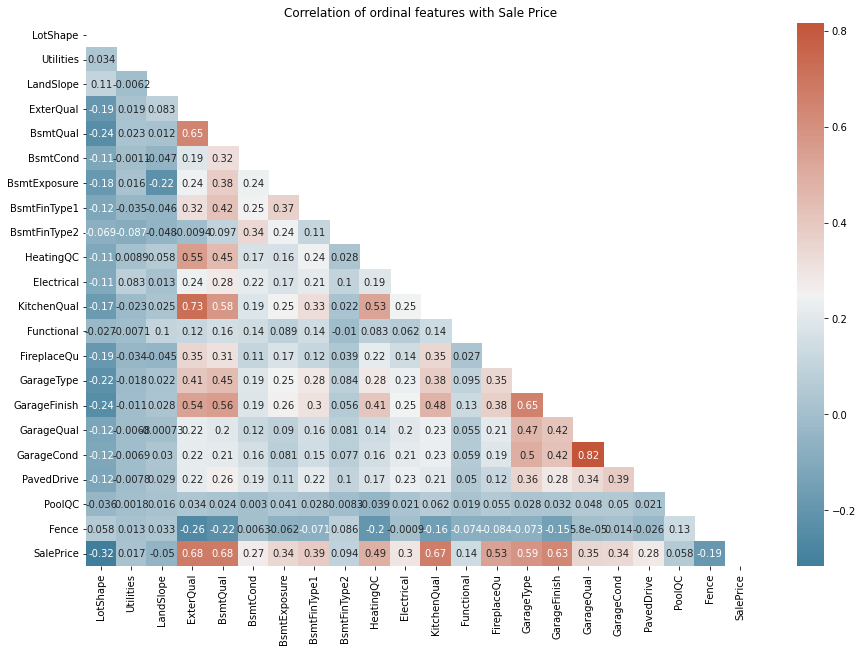

In [ ]:
f = plt.figure(figsize=(15, 10))
df_ord_cat_salePrice= train_df_cat[ordinal_cat_features]
df_ord_cat_salePrice['SalePrice']= train_df['SalePrice']
corr = df_ord_cat_salePrice.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask=mask, annot= True)
plt.title('Correlation of ordinal features with Sale Price')

Thereis no serious multicollinearity among the ordinal variables, thus none will be dropped. 'ExterQual', 'KitchenQual' and 'BsmtQual'are strongly correlated with SalePrice

##### **Nominal Variables**

In [ ]:
nominal_cat_features= ['MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 
       'Heating', 'MiscFeature', 'SaleType', 'SaleCondition']

<Figure size 720x576 with 0 Axes>

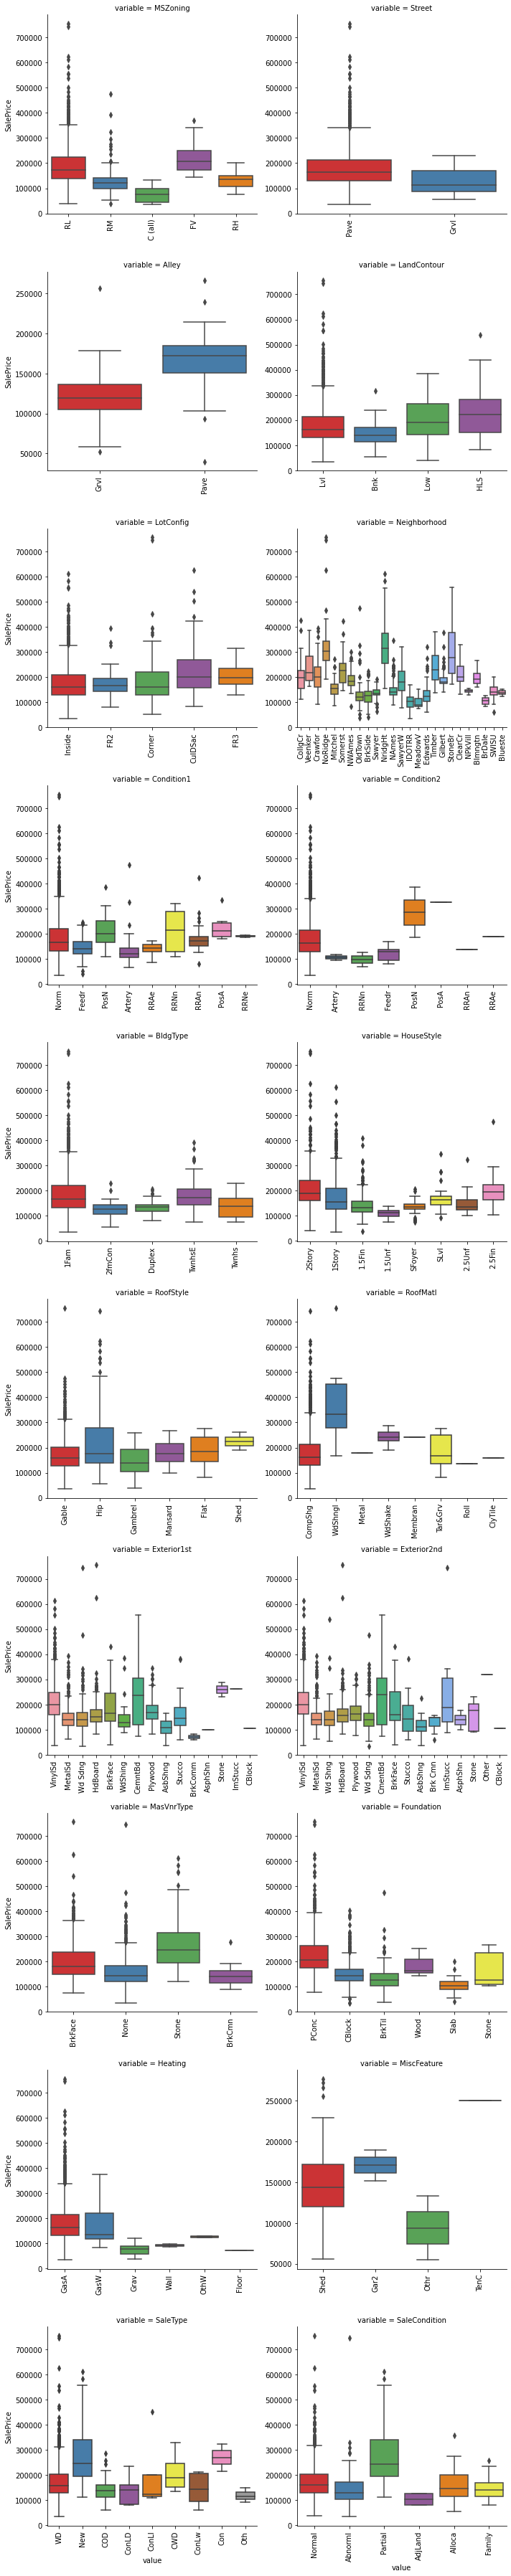

In [ ]:
fig = plt.figure(figsize=(10, 8))
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train_df, id_vars=['SalePrice'], value_vars=nominal_cat_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=5)
g = g.map(boxplot, "value", "SalePrice")

Neighborhood has big impact on house prices. Having pool in the building increases the price substantially

#### **Preprocessing**

##### **Data Cleaning**

In [ ]:
train_df_numeric['LotFrontage'] = train_df_numeric['LotFrontage'].fillna(train_df_numeric['LotFrontage'].median())
train_df_numeric['MasVnrArea'] = train_df_numeric['MasVnrArea'].fillna(train_df_numeric['MasVnrArea'].median())
train_df_numeric['GarageYrBlt'] = train_df_numeric['GarageYrBlt'].fillna(0)

train_df_cat[ordinal_cat_features]= train_df_cat[ordinal_cat_features].fillna(0)

train_df_cat['MasVnrType'] = train_df_cat['MasVnrType'].fillna(train_df_cat['MasVnrType'].mode()[0])

##### **Feature Engineering**

##### **Generating new features**

In [ ]:
train_df_numeric["LivLotRatio"] = train_df_numeric["GrLivArea"] / train_df_numeric["LotArea"]
train_df_numeric["Spaciousness"] = (train_df_numeric["1stFlrSF"] + train_df_numeric["2ndFlrSF"]) / train_df_numeric["TotRmsAbvGrd"]
train_df_numeric["TotalOutsideSF"] = train_df_numeric['WoodDeckSF'] + train_df_numeric['OpenPorchSF'] + train_df_numeric['EnclosedPorch'] + train_df_numeric["3SsnPorch"] + train_df_numeric["ScreenPorch"]
train_df_numeric["PorchCount"] = train_df_numeric[["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]].gt(0.0).sum(axis=1)

train_df_numeric["OverallGrade"] = train_df_numeric["OverallQual"] * train_df_numeric["OverallCond"]
train_df_numeric["GarageGrade"] = train_df_cat["GarageQual"]* train_df_cat["GarageCond"]
train_df_numeric["ExterGrade"] = train_df_cat["ExterQual"] * train_df_cat["ExterCond"]
train_df_numeric["KitchenGrade"] = train_df_numeric["KitchenAbvGr"] * train_df_cat["KitchenQual"]
train_df_numeric["FireplaceGrade"] = train_df_numeric["Fireplaces"] * train_df_cat["FireplaceQu"]
train_df_numeric["GarageGrade"] = train_df_numeric["GarageArea"] * train_df_cat["GarageQual"]
train_df_numeric["GarageScore"] = train_df_numeric["GarageArea"] * train_df_cat["GarageQual"]
train_df_numeric["TotalBath"] = train_df_numeric["BsmtFullBath"] + (0.5 * train_df_numeric["BsmtHalfBath"]) + train_df_numeric["FullBath"] + (0.5 * train_df_numeric["HalfBath"])
train_df_numeric["AllSF"] = train_df_numeric["GrLivArea"] + train_df_numeric["TotalBsmtSF"]
train_df_numeric["house_age"] = train_df_numeric["YearBuilt"].apply(lambda x: pd.datetime.now().year - x)
train_df_numeric["no_years_since_sold"] = train_df_numeric["YrSold"].apply(lambda x: pd.datetime.now().year - x)

def season(month_sold):
    if month_sold >= 3 and month_sold <= 5:
        return 'spring'
    elif month_sold >= 6 and month_sold <= 8:
        return 'summer'
    elif month_sold >= 9 and month_sold <= 11:
        return 'autumn'
    else:
        return 'winter'

train_df_cat["sale_season"] = train_df_numeric["MoSold"].apply(season)

BldgType_dummy = pd.get_dummies(train_df_cat.BldgType, prefix="Bldg")
new_features1 = BldgType_dummy.mul(train_df_numeric.GrLivArea, axis=0)

new_features2= pd.DataFrame()

new_features2["Median_neigh_area"] = train_df.groupby("Neighborhood")["GrLivArea"].transform("median")


train_df_numeric = train_df_numeric.join([new_features1, new_features2])

train_df_cat["HasMasVnr"] = train_df_cat['MasVnrType'].replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  app.launch_new_instance()


Text(0.5, 1.0, 'top strongly correlated features with Sale Price')

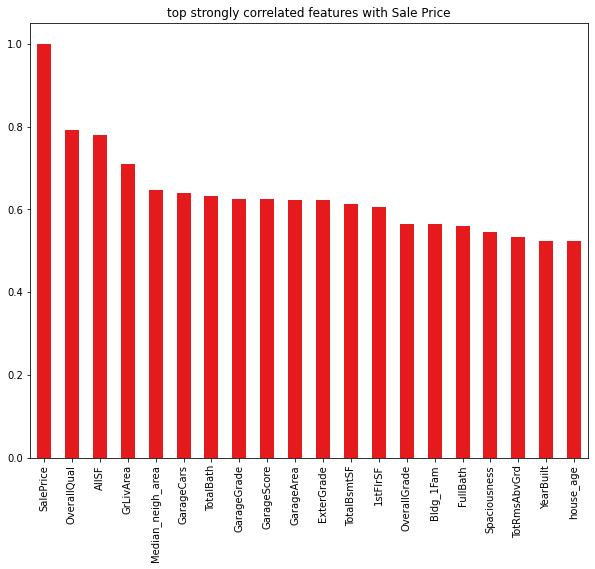

In [ ]:
# Finding top strongly correlated features with target

fig = plt.figure(figsize=(10, 8))
strong_features= train_df_numeric.corr()['SalePrice'].abs().nlargest(20)
strong_features.plot.bar()
plt.title('top strongly correlated features with Sale Price')

In [ ]:
train_df_numeric["OverallQual_2"] = train_df_numeric["OverallQual"] ** 2
train_df_numeric["OverallQual_3"] = train_df_numeric["OverallQual"] ** 3
train_df_numeric["OverallQual_sq"] = np.sqrt(train_df_numeric["OverallQual"])

train_df_numeric["AllSF_2"] = train_df_numeric["AllSF"] ** 2
train_df_numeric["AllSF_3"] = train_df_numeric["AllSF"] ** 3
train_df_numeric["AllSF_sq"] = np.sqrt(train_df_numeric["AllSF"])

train_df_numeric["GrLivArea_2"] = train_df_numeric["GrLivArea"] ** 2
train_df_numeric["GrLivArea_3"] = train_df_numeric["GrLivArea"] ** 3
train_df_numeric["GrLivArea_sq"] = np.sqrt(train_df_numeric["GrLivArea"]
                                           )
train_df_numeric["Median_neigh_area_2"] = train_df_numeric["Median_neigh_area"] ** 2
train_df_numeric["Median_neigh_area_3"] = train_df_numeric["Median_neigh_area"] ** 3
train_df_numeric["Median_neigh_area_sq"] = np.sqrt(train_df_numeric["Median_neigh_area"])

train_df_numeric["GarageCars_2"] = train_df_numeric["GarageCars"] ** 2
train_df_numeric["GarageCars_3"] = train_df_numeric["GarageCars"] ** 3
train_df_numeric["GarageCars_sq"] = np.sqrt(train_df_numeric["GarageCars"])

train_df_numeric["TotalBath_2"] = train_df_numeric["TotalBath"] ** 2
train_df_numeric["TotalBath_3"] = train_df_numeric["TotalBath"] ** 3
train_df_numeric["TotalBath_sq"] = np.sqrt(train_df_numeric["TotalBath"])

train_df_numeric["GarageScore_2"] = train_df_numeric["GarageScore"] ** 2
train_df_numeric["GarageScore_3"] = train_df_numeric["GarageScore"] ** 3
train_df_numeric["GarageScore_sq"] = np.sqrt(train_df_numeric["GarageScore"])

train_df_numeric["GarageGrade_2"] = train_df_numeric["GarageGrade"] ** 2
train_df_numeric["GarageGrade_3"] = train_df_numeric["GarageGrade"] ** 3
train_df_numeric["GarageGrade_sq"] = np.sqrt(train_df_numeric["GarageGrade"])

train_df_numeric["GarageArea_2"] = train_df_numeric["GarageArea"] ** 2
train_df_numeric["GarageArea_3"] = train_df_numeric["GarageArea"] ** 3
train_df_numeric["GarageArea_sq"] = np.sqrt(train_df_numeric["GarageArea"])

train_df_numeric["ExterGrade_2"] = train_df_numeric["ExterGrade"] ** 2
train_df_numeric["ExterGrade_3"] = train_df_numeric["ExterGrade"] ** 3
train_df_numeric["ExterGrade_sq"] = np.sqrt(train_df_numeric["ExterGrade"])

train_df_numeric["TotalBsmtSF_2"] = train_df_numeric["TotalBsmtSF"] ** 2
train_df_numeric["TotalBsmtSF_3"] = train_df_numeric["TotalBsmtSF"] ** 3
train_df_numeric["TotalBsmtSF_sq"] = np.sqrt(train_df_numeric["TotalBsmtSF"])

train_df_numeric["1stFlrSF_2"] = train_df_numeric["1stFlrSF"] ** 2
train_df_numeric["1stFlrSF_3"] = train_df_numeric["1stFlrSF"] ** 3
train_df_numeric["1stFlrSF_sq"] = np.sqrt(train_df_numeric["1stFlrSF"])

train_df_numeric["OverallGrade_2"] = train_df_numeric["OverallGrade"] ** 2
train_df_numeric["OverallGrade_3"] = train_df_numeric["OverallGrade"] ** 3
train_df_numeric["OverallGrade_sq"] = np.sqrt(train_df_numeric["OverallGrade"])

train_df_numeric["Bldg_1Fam_2"] = train_df_numeric["Bldg_1Fam"] ** 2
train_df_numeric["Bldg_1Fam_3"] = train_df_numeric["Bldg_1Fam"] ** 3
train_df_numeric["Bldg_1Fam_sq"] = np.sqrt(train_df_numeric["Bldg_1Fam"])

train_df_numeric["FullBath_2"] = train_df_numeric["FullBath"] ** 2
train_df_numeric["FullBath_3"] = train_df_numeric["FullBath"] ** 3
train_df_numeric["FullBath_sq"] = np.sqrt(train_df_numeric["FullBath"])

In [ ]:
skewness = train_df_numeric.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
skewed_features = skewness.index
train_df_numeric[skewed_features] = np.log1p(train_df_numeric[skewed_features])
print(str(skewness.shape[0]) + " skewed numerical features was normalised")

83 skewed numerical features was normalised


In [ ]:
train_df_numeric['HasBasement'] = train_df_numeric['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train_df_numeric['HasGarage'] = train_df_numeric['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train_df_numeric['Has2ndFloor'] = train_df_numeric['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train_df_numeric['HasWoodDeck'] = train_df_numeric['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train_df_numeric['HasPorch'] = train_df_numeric['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train_df_numeric['HasPool'] = train_df_numeric['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train_df_numeric['IsNew'] = train_df_numeric['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)
train_df_numeric["Has_LowQualFinSF"] = train_df_numeric["LowQualFinSF"].apply(lambda x: 1 if x > 0 else 0)
train_df_numeric["RecentRemodLargeBsmt"] = train_df_numeric.YearRemodAdd * train_df_numeric.TotalBsmtSF

In [ ]:
cleaned_train_df= pd.concat([train_df_numeric, train_df_cat], axis= 1)

cleaned_train_df.drop(['GarageYrBlt','GarageCond', 'Utilities', 'Alley', 'MiscFeature', 'YearBuilt', 'YrSold', 'Street'], axis= 1, inplace= True)

In [ ]:
cleaned_train_df.shape

(1460, 148)

In [ ]:
cleaned_train_df.to_csv('cleaned_train_data.csv', index= False)